In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools#final dest reached?

import pulp

## Step 1: Setup and draw test network

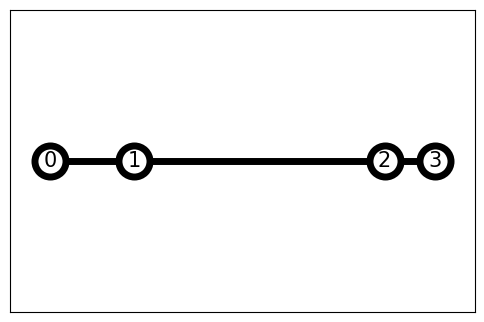

In [2]:
#setup grid
fig,ax=plt.subplots(dpi=100)

#create graph
G = nx.Graph()

#give in node list
nodes=[0,1,2,3]

#edge weights (dist in between)
dist=[50,150,30]


#make weighted edge list to add, then fill
edges=[]
for i in range(len(nodes)-1):
    edges.append((nodes[i],nodes[i+1],dist[i]))
    
#add weighted edges
G.add_weighted_edges_from(edges)

#explicitly set positions to match distances (just for visualization)
#first node is at (0,0)
pos_dict={0:(0,0)}
#other nodes are at summed dist to the right
for i in range(len(dist)):
    pos_dict[(i+1)]=(sum(dist[:(i+1)]),0)

#plotting options
options = {
    "font_size": 15,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

#plot
nx.draw_networkx(G, pos=pos_dict, **options, labels={node: node for node in G.nodes()})

## Step 2: Deterimine which combinations can refuel each path

In [3]:
#this script is copied from: https://stackoverflow.com/questions/50634876/how-can-you-remove-superset-lists-from-a-list-of-lists-in-python
def get_minimal_subsets(sets):
    sets = sorted(map(set, sets), key=len)
    minimal_subsets = []
    for s in sets:
        if not any(minimal_subset.issubset(s) for minimal_subset in minimal_subsets):
            minimal_subsets.append(s)
    #added, converge to tuple
    tuples_inside = [tuple (k) for k in minimal_subsets]

    return tuples_inside

In [4]:
def first_stage_FRLM(G, r, OD):
    """ 
    Returns feasible charging station combinations for transport network G for routes in OD, considering travel range r, assuming that charging stations can be placed on any node of G. 
    Parameters
    ----------
    G : NetworkX graph
        must include all origins, desinations and any nodes where a refueling station may be placed.
    r : float
        range means of transport with full tank.
    OD: list 
        list of travel data within network G, travel data from A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(node_1, node_2, flow_12),(node_1, node_3, flow_13),(node_2, node_3, flow_23)]
        """
    #get data from graph in list format
    node_list = [i for i in G.nodes]
    edge_list = [i for i in G.edges]
    edge_list_w = []
    
    # Now also create weighted edge list in the format [(begin, start, weight),(..), etc.]
    for origin, destination in edge_list:
        edge_list_w.append((origin,destination,G.get_edge_data(origin,destination)['weight']))
    
    #collect paths to refuel and path lengths in dicts, first create empty dicts
    paths = {}
    path_lengths = {}
    
    #dict to collect eq and fq values
    dict_eq_fq = {'q':[], 'e_q':[], 'f_q':[]}
    
    #generate shortest paths for al origin destinations
    for origin, destination, flow in OD:
        paths[(origin,destination)] = nx.dijkstra_path(G,origin,destination)
        path_lengths[(origin,destination)] = nx.dijkstra_path_length(G,origin,destination,weight='weight')
        
        #fill dict for eq_fq dataframe
        dict_eq_fq['q'].append((origin,destination))
        dict_eq_fq['f_q'].append(flow)
        dict_eq_fq['e_q'].append((1/(max(1,int(r/(path_lengths[(origin,destination)]*2))))))
    
    #make master dict with key q, with list of all feasible station combinations on q with r
    route_refuel_comb = {}
    for route_key,combis in paths.items():
        h=[]
        # #functioning shortcut, now not nessecary: check if single station is enough
        # if r >= path_lengths[i]:
        #     h = [tuple (k) for k in str(j)]
        #     route_refuel_comb[i] = h
        # else:
        # create all possible station combinations on this path
        for L in range (0, len(combis)+1):
                for k in itertools.combinations(combis, (L+1)):
                    h.append(k)
        #now add to dict:
        route_refuel_comb[route_key] = h
        
    #now check feasibility
    #new master dict to store feasible combinations
    feasible_combinations = {}
    
    for route_key, route in route_refuel_comb.items():
        feasible_combinations[route_key] = []
        #store path for this route (on which round trip should be feasible) 
        path = paths[route_key]
        round_trip = path[:-1] + path[::-1]
        
        #now loop through all possible station combinations
        for combi in route:
            #start at origin
            current_pos = round_trip[0]
            #start with full range if refueling station at origin, otherwise half full
            if current_pos in combi:
                current_range = r
            else:
                current_range = r*0.5
            #simulate power levels during round trip
            #[1:] because first dest is second entry round trip list
            for sub_dest in round_trip[1:]:
#               #try to travel to new dest, first calculate dist to new destination
                dist = G.get_edge_data(current_pos,sub_dest)['weight']
                #only travel if dist is not too long
                if (current_range - dist) >= 0:
                    #if there is fuel station at destination: trip feasible
                    if (sub_dest in combi):
                        #final dest reached?
                        if (sub_dest == path[-1]):
                            feasible_combinations[route_key].append(combi)
                            break
                    #else: maybe feasible, double back route to check!
                    else:
                        if (sub_dest == path[0]):
                            feasible_combinations[route_key].append(combi)
                            break
                    #if not at final destination update range and pos
                    current_pos = sub_dest
                    current_range -= dist
                    #if there is a refueling station, refuel
                    if sub_dest in combi:
                        current_range = r
                    #check if at final dest
                else:
                    break
    
    #next: find and remove supersets
    for i,j in feasible_combinations.items():
        feasible_combinations[i] = get_minimal_subsets(feasible_combinations[i])
    #Reformat data: create two dicts one with b_qh values and one with g_qhk values
    #first create list of all possible combinations
    combinations=[]
    for i in feasible_combinations.values():
        combinations+=i

    #remove duplicates
    combinations =list(set(combinations))

    #setup empty dict with keys to fill with b_qh values
    dict_b = {'q':[]}
    #column for each unique combi
    for j in combinations:
            dict_b[j] = []
    
    #first dict_
    for route_key, combinations_route in feasible_combinations.items():
        dict_b['q'].append(route_key)
        for combination in combinations:
            if combination in combinations_route:
                dict_b[combination].append(1)
            else:
                dict_b[combination].append(0)



    
    #setup next dict to store g_qhk values
    dict_g={'q':[],'h':[]}
    
    for node in node_list:
        dict_g[node] = []
    
    #fill second dict for g_qhk    
    for route_key, route in feasible_combinations.items():
        for combination in route:
            dict_g['q'].append(route_key)
            dict_g['h'].append(combination)
            for node in node_list:
                if node in combination:
                    if node in route_key:
                        dict_g[node].append(1)
                    else:
                        dict_g[node].append(2)
                else:
                    dict_g[node].append(0)
    
    #create dicts to return and set index right
    df_b = pd.DataFrame.from_dict(dict_b)
    df_b.set_index('q', inplace=True)
    
    df_g = pd.DataFrame.from_dict(dict_g)
    df_g.set_index(['q','h'], inplace=True)
    
    df_eq_fq = pd.DataFrame.from_dict(dict_eq_fq)
    df_eq_fq.set_index('q', inplace=True)
    
    return df_b, df_g, df_eq_fq

In [5]:
#import time to check performance
import time

df_b, df_g, df_eq_fq = first_stage_FRLM(G, 500, [(0,3,10),(0,2,5)])

## Dataframes that result from first stage

The DataFrames below will be used in the optimization

In [6]:
df_b

,"(1,)","(2,)","(3,)"
q,,,
"(0, 3)",1,1,1
"(0, 2)",1,1,0


In [7]:
df_g

0  1  2  3
q      h               
(0, 3) (1,)  0  2  0  0
       (2,)  0  0  2  0
       (3,)  0  0  0  1
(0, 2) (1,)  0  2  0  0
       (2,)  0  0  1  0

In [8]:
df_eq_fq

,e_q,f_q
q,,
"(0, 3)",1.0,10
"(0, 2)",1.0,5


## Step 3: PULP optimisation
Examples used: Python dictaat H3 and http://benalexkeen.com/linear-programming-with-python-and-pulp-part-5/

(later on maybe try more efficient solver)

In [9]:
#import pulp module
from pulp import *

### Input variables

In [10]:
c=10000 #capacity: now set to large
p=2 #amount of stations to place

### Define decision variables

In [11]:
# define y_qh for each q and each h, and restrict between 0 and 1
# constraint 1.5 already incorporated
flow_allocation = pulp.LpVariable.dicts("Flow_captured",
                                     ((q, h) for q, h in df_g.index),
                                     lowBound=0,
                                     upBound=1,
                                     cat='Continuous')

In [12]:
# amount of facilities to place at each site is also decision var
facilities_to_build = pulp.LpVariable.dicts("Facilities",
                                     (facility for facility in df_g.columns),
                                     lowBound=0,
                                     cat='Integer')

### Define problem and objective function

In [13]:
# Define problem
model = LpProblem('CFRLM', LpMaximize)

From this point, formula is above implementation

$ Max\;Z = \sum_{q \,\in\,Q}\,\sum_{h\in H|b_{qh}=1}\,f_q\,y_{qh} $

In [14]:
#objective function
model += pulp.lpSum(
    [flow_allocation[q,h] * df_b[h][q] * df_eq_fq['f_q'][q] for q,h in df_g.index]
)
#seems to work!

### Define constraints

$ \sum_{q \,\in\,Q}\,\sum_{h\in H|b_{qh}=1}\,e_q\,g_{qhk}\,f_q\,y_{qh} \leq c\,x_k \:\:\: \forall k \in K $

In [15]:
# first constraint (1.2 in paper)

# for each facility
for key, facility in facilities_to_build.items():
    model+= pulp.lpSum(df_eq_fq['e_q'][q] * df_g[key].loc[df_g.index == (q,h)] * df_eq_fq['f_q'][q] * flow_allocation[q,h] for q,h in df_g.index) <= pulp.lpSum(c* facility)

$ \sum_{k \in K} x_k = p $

In [16]:
#second constraint (1.3 in paper)
model += pulp.lpSum(facilities_to_build[i] for i in range(len(facilities_to_build.keys()))) <= p

#works

$ \sum_{h \in H|b_{qh} = 1} y_{qh} \leq 1 \:\:\: \forall q \in Q $

In [17]:
#third constraint (1.4 in paper)
for q in df_b.index:
    model += pulp.lpSum([flow_allocation[q,h] * df_b[h][q]] for h in df_g.loc[q].index) <= 1

#now works, error solved!

## Check if formulation is OK

In [18]:
print(model)

CFRLM:
MAXIMIZE
5*Flow_captured_((0,_2),_(1,)) + 5*Flow_captured_((0,_2),_(2,)) + 10*Flow_captured_((0,_3),_(1,)) + 10*Flow_captured_((0,_3),_(2,)) + 10*Flow_captured_((0,_3),_(3,)) + 0
SUBJECT TO
_C1: - 10000 Facilities_0 <= 0

_C2: - 10000 Facilities_1 + 10 Flow_captured_((0,_2),_(1,))
 + 20 Flow_captured_((0,_3),_(1,)) <= 0

_C3: - 10000 Facilities_2 + 5 Flow_captured_((0,_2),_(2,))
 + 20 Flow_captured_((0,_3),_(2,)) <= 0

_C4: - 10000 Facilities_3 + 10 Flow_captured_((0,_3),_(3,)) <= 0

_C5: Facilities_0 + Facilities_1 + Facilities_2 + Facilities_3 <= 2

_C6: Flow_captured_((0,_3),_(1,)) + Flow_captured_((0,_3),_(2,))
 + Flow_captured_((0,_3),_(3,)) <= 1

_C7: Flow_captured_((0,_2),_(1,)) + Flow_captured_((0,_2),_(2,)) <= 1

VARIABLES
0 <= Facilities_0 Integer
0 <= Facilities_1 Integer
0 <= Facilities_2 Integer
0 <= Facilities_3 Integer
Flow_captured_((0,_2),_(1,)) <= 1 Continuous
Flow_captured_((0,_2),_(2,)) <= 1 Continuous
Flow_captured_((0,_3),_(1,)) <= 1 Continuous
Flow_capture

In [19]:
# Not quite right yet... (as expected looking at result)

## Now solve problem

All other constraints are already incorporated as low/upbounds when defining decision variables above

In [20]:
# Solve LP problem
model.solve()

# Controleer of het optimum is gevonden
print("Status:", LpStatus[model.status])

Status: Optimal


In [21]:
# Values of decision variables at optimum
for var in model.variables():
    print('Variable', var,'is equal to', value(var))
    
# Value of objective at optimum
print('Total supported flow is equal to', value(model.objective))

Variable Facilities_0 is equal to 0.0
Variable Facilities_1 is equal to 1.0
Variable Facilities_2 is equal to 0.0
Variable Facilities_3 is equal to 1.0
Variable Flow_captured_((0,_2),_(1,)) is equal to 1.0
Variable Flow_captured_((0,_2),_(2,)) is equal to 0.0
Variable Flow_captured_((0,_3),_(1,)) is equal to 1.0
Variable Flow_captured_((0,_3),_(2,)) is equal to 0.0
Variable Flow_captured_((0,_3),_(3,)) is equal to 0.0
Total supported flow is equal to 15.0


In [22]:
#in function form now.
def second_stage_FRLM(p, c, df_g, df_b, df_eq_fq):
    """ This program optimally sites n charging stations with a max capacity c,
    based on three DataFrames that are generated by the first_stage_FRLM function.
        Parameters
        ----------
        p : int
            #charging stations modules to locate on any node of G.

        c : float
            max (average) flow a charging station can cope with.

        ## the following three inputs are data frames that can be generated using the first_stage_FRLM function
        df_g : pd.DataFrame()
            DataFrame with a row for each route q and a column for each existing charging station combination h.
            b_qh = 1 combination h can support trips on path h, 0 otherwise.

        df_b : pd.DataFrame()
            DataFrame with a row for each charging station combination h, and a column for each unique facility k.
            a_qh = 1 if combination k is in combination h, 0 otherwise.

        df_eq_fq : pd.DataFrame()
            Dataframe with a row for each route q, that contains two columns corresponding f_q and e_q values.
        """

    # define y_qh for each q and each h, and restrict between 0 and 1
# constraint 1.5 already incorporated
    flow_allocation = pulp.LpVariable.dicts("Flow_captured",
                                         ((q, h) for q, h in df_g.index),
                                         lowBound=0,
                                         upBound=1,
                                         cat='Continuous')

    # amount of facilities to place at each site is also decision var
    facilities_to_build = pulp.LpVariable.dicts("Facilities",
                                     (facility for facility in df_g.columns),
                                     lowBound=0,
                                     cat='Integer')
    # Define problem
    model = LpProblem('CFRLM', LpMaximize)

    #objective function
    model += pulp.lpSum([flow_allocation[q,h] * df_b[h][q] * df_eq_fq['f_q'][q] for q,h in df_g.index])

    ################################################constraints##################################################
    # first constraint
    # for each facility
    for key, facility in facilities_to_build.items():
        model+= pulp.lpSum(df_eq_fq['e_q'][q] * df_g[key].loc[df_g.index == (q,h)] * df_eq_fq['f_q'][q] * flow_allocation[q,h] for q,h in df_g.index) <= pulp.lpSum(c* facility)

    #second constraint
    model += pulp.lpSum(facilities_to_build[i] for i in range(len(facilities_to_build.keys()))) <= p

    #third constraint
    for q in df_b.index:
        model += pulp.lpSum([flow_allocation[q,h] * df_b[h][q]] for h in df_g.loc[q].index) <= 1

    # print(model)
    #solve
    model.solve()

    status=LpStatus[model.status]
    print(status)
    # Values of decision variables at optimum


    for var in model.variables():
        print('Variable', var, 'is equal to', value(var))

    # Value of objective at optimum
    print('Total supported flow is equal to', value(model.objective))

    #create useful output
    dict_fac ={}
    for var in model.variables():
        dict_fac[var] = value(var)

    return dict_fac


## Try functions

In [23]:
df_b, df_g, df_eq_fq = first_stage_FRLM(G, 500, [(0,3,10),(0,2,5)])

In [24]:
locations = second_stage_FRLM(2, 20, df_g, df_b, df_eq_fq)

Optimal
Variable Facilities_0 is equal to 0.0
Variable Facilities_1 is equal to 1.0
Variable Facilities_2 is equal to 1.0
Variable Facilities_3 is equal to 0.0
Variable Flow_captured_((0,_2),_(1,)) is equal to 0.0
Variable Flow_captured_((0,_2),_(2,)) is equal to 1.0
Variable Flow_captured_((0,_3),_(1,)) is equal to 0.25
Variable Flow_captured_((0,_3),_(2,)) is equal to 0.75
Variable Flow_captured_((0,_3),_(3,)) is equal to 0.0
Total supported flow is equal to 15.0


In [25]:
locations

{Facilities_0: 0.0,
 Facilities_1: 1.0,
 Facilities_2: 1.0,
 Facilities_3: 0.0,
 Flow_captured_((0,_2),_(1,)): 0.0,
 Flow_captured_((0,_2),_(2,)): 1.0,
 Flow_captured_((0,_3),_(1,)): 0.25,
 Flow_captured_((0,_3),_(2,)): 0.75,
 Flow_captured_((0,_3),_(3,)): 0.0}

# Old from here: some tries other optimisation package:

In [26]:
## 1
from ortools.linear_solver import pywraplp

def second_stage_FRLM_opt(G, n, c, df_qh, df_hk, df_eq_fq):
    """ This program optimally sites n charging stations for vehicles with a range r, based on two DataFrames that are generated by the first_stage_FRLM function.
        Parameters
        ----------
        G : NetworkX graph
            must include all origins, desinations and any nodes where a refueling station may be placed.
        n : int
            #stations to locate on any node of G.
        c : float
            max average flow a charging station can cope with.
        df_qh : pd.DataFrame()
            DataFrame with a row for each route (q) and a column for each existing charging station combination (h). b_qh = 1 combination h can support trips on path h, 0 otherwise.
            df_qh is generated by the first_stage_FRLM function.
        df_kh : pd.DataFrame()
            DataFrame with a row for each charging station combination (h), and a column for each unique facility (k). a_qh = 1 if combination k is in combination h, 0 otherwise.   
            df_kh is generated by the first_stage_FRLM function.
        OD: list 
        list of travel data within network G, travel data from A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(node_1, node_2, flow_12),(node_1, node_3, flow_13),(node_2, node_3, flow_23)]
        
        """
    ## 2 Create a solver using the GLOP backend
    solver = pywraplp.Solver('Maximize captured flow', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    
    ## 3 define the decision variables
    
    #create decision variables, decision: realize charging station combination or not
    x = {}
    #loop over all combinations
    for j in range(len(df1.columns[1:])):
        #create decision variable for each combination, build (1) or not (0).
        x[j] = solver.IntVar(0, 1, 'x[%i]' % j)
    print('Number of variables =', solver.NumVariables())
    
    ## 4 define constraints
    #total amount of charging stations may not exceed n
    x = 
    solver.Add(
    print('Number of constraints =', solver.NumConstraints())

    
    



SyntaxError: invalid syntax (2437112806.py, line 41)

In [ ]:
second_stage_FRLM(G, 1, 10, df1, df2)

In [ ]:
## Also test with larger graph
example taken:
https://networkx.org/documentation/stable/auto_examples/drawing/plot_tsp.html#sphx-glr-auto-examples-drawing-plot-tsp-py

In [ ]:
# #test with larger network?
# import networkx.algorithms.approximation as nx_app
# import math

# G2=nx.random_geometric_graph(20, radius=0.4, seed=3)
# pos = nx.get_node_attributes(G2, "pos")

# # Depot should be at (0,0)
# pos[0] = (0.5, 0.5)

# H = G2.copy()


# # Calculating the distances between the nodes as edge's weight.
# for i in range(len(pos)):
#     for j in range(i + 1, len(pos)):
#         dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
#         dist = dist
#         G2.add_edge(i, j, weight=dist)
#         # print(dist)

# cycle = nx_app.christofides(G2, weight="weight")
# edge_list = list(nx.utils.pairwise(cycle))

# # Draw closest edges on each node only
# nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# # Draw the route
# nx.draw_networkx(
#     G2,
#     pos,
#     with_labels=True,
#     edgelist=edge_list,
#     edge_color="red",
#     node_size=200,
#     width=3,
# )

# print("The route of the traveller is:", cycle)
# plt.show()

In [ ]:
# %time dict_df1, dict_df2 = first_stage_FRLM(G2, 1, [(19,5,10),(4,8,5)])
#oops complete graph chosen, bad example..

In [ ]:
# Define problem
model = LpProblem('CFRLM', LpMaximize)

In [ ]:
#objective function
model += pulp.lpSum(
    [flow_allocation[q,h] * df_b[h][q] * df_eq_fq['f_q'][q] for q,h in df_g.index]
)

### Define constraints

In [ ]:
# first constraint (1.2 in paper)

# for all q
for q in df_b.index:
    # for all h
    for h in df_b.columns:
        # that can serve q
        if df_b[h][q] == 1:
            for k in h:
                model += pulp.lpSum(df_eq_fq['e_q'][q] * df_g.loc[df_g.index == (q,h)] * df_eq_fq['f_q'][q] * flow_allocation[q,h]) <= c*pulp.lpSum(facilities_to_build)

In [ ]:
#second constraint (1.3 in paper)
model += pulp.lpSum(facilities_to_build) <= p

In [ ]:
#third constraint (1.4 in paper)
model += pulp.lpSum([flow_allocation[q,h] * df_b[h][q]]) <= 1

In [ ]:
# Solve LP problem
model.solve()

# Controleer of het optimum is gevonden
print("Status:", LpStatus[model.status])

In [ ]:
# De waarden van de beslissingsvariabelen in het optimum
for var in model.variables():
    print('De stroom', var,'bedraagt', value(var))
    
# De waarde van de doelfunctie in het optimum
print('De totale maximale stroom bedraagt', value(model.objective))

## Step 3: Optimize

Basic steps:
1. Import the linear solver wrapper,
2. declare the LP solver,
3. define the variables,
4. define the constraints,
5. define the objective,
6. call the LP solver; and
7. display the solution

Based on:
- https://towardsdatascience.com/introduction-to-linear-programming-in-python-9261e7eb44b
- https://developers.google.com/optimization/mip/mip_var_array
- https://developers.google.com/optimization/lp/lp_example

In [ ]:
import pulp


In [ ]:
#manual try
def second_stage_FRLM(G, n, c, df_qh, df_hk, OD):
    """ This program optimally sites n charging stations for vehicles with a range r, based on two DataFrames that are generated by the first_stage_FRLM function.
        Parameters
        ----------
        G : NetworkX graph
            must include all origins, desinations and any nodes where a refueling station may be placed.
        n : int
            #stations to locate on any node of G.
        c : float
            max average flow a charging station can cope with.
        df_qh : pd.DataFrame()
            DataFrame with a row for each route (q) and a column for each existing charging station combination (h). b_qh = 1 combination h can support trips on path h, 0 otherwise.
            df_qh is generated by the first_stage_FRLM function.
        df_kh : pd.DataFrame()
            DataFrame with a row for each charging station combination (h), and a column for each unique facility (k). a_qh = 1 if combination k is in combination h, 0 otherwise.   
            df_kh is generated by the first_stage_FRLM function.
        OD: list 
        list of travel data within network G, travel data from A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(node_1, node_2, flow_12),(node_1, node_3, flow_13),(node_2, node_3, flow_23)]
        
        """
    #step 1: create empty list with placed fuel stations
    stations = []
    
    #step 2:

In [ ]:
## 1
from ortools.linear_solver import pywraplp

def second_stage_FRLM_opt(G, n, c, df_qh, df_hk):
    """ This program optimally sites n charging stations for vehicles with a range r, based on two DataFrames that are generated by the first_stage_FRLM function.
        Parameters
        ----------
        G : NetworkX graph
            must include all origins, desinations and any nodes where a refueling station may be placed.
        n : int
            #stations to locate on any node of G.
        c : float
            max average flow a charging station can cope with.
        df_qh : pd.DataFrame()
            DataFrame with a row for each route (q) and a column for each existing charging station combination (h). b_qh = 1 combination h can support trips on path h, 0 otherwise.
            df_qh is generated by the first_stage_FRLM function.
        df_kh : pd.DataFrame()
            DataFrame with a row for each charging station combination (h), and a column for each unique facility (k). a_qh = 1 if combination k is in combination h, 0 otherwise.   
            df_kh is generated by the first_stage_FRLM function.
        OD: list 
        list of travel data within network G, travel data from A-B and from B-A should be summed up and entered as either one of them.
        example input:
        [(node_1, node_2, flow_12),(node_1, node_3, flow_13),(node_2, node_3, flow_23)]
        
        """
    ## 2 Create a solver using the GLOP backend
    solver = pywraplp.Solver('Maximize captured flow', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    
    ## 3 define the decision variables
    
    #create decision variables, decision: realize charging station combination or not
    x = {}
    #loop over all combinations
    for j in range(len(df1.columns[1:])):
        #create decision variable for each combination, build (1) or not (0).
        x[j] = solver.IntVar(0, 1, 'x[%i]' % j)
    print('Number of variables =', solver.NumVariables())
    
    ## 4 define constraints
    #total amount of charging stations may not exceed n
    x = 
    solver.Add(
    print('Number of constraints =', solver.NumConstraints())

    
    



In [ ]:
second_stage_FRLM(G, 1, 10, df1, df2)

In [ ]:
## Also test with larger graph
example taken:
https://networkx.org/documentation/stable/auto_examples/drawing/plot_tsp.html#sphx-glr-auto-examples-drawing-plot-tsp-py

In [ ]:
# #test with larger network?
# import networkx.algorithms.approximation as nx_app
# import math

# G2=nx.random_geometric_graph(20, radius=0.4, seed=3)
# pos = nx.get_node_attributes(G2, "pos")

# # Depot should be at (0,0)
# pos[0] = (0.5, 0.5)

# H = G2.copy()


# # Calculating the distances between the nodes as edge's weight.
# for i in range(len(pos)):
#     for j in range(i + 1, len(pos)):
#         dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
#         dist = dist
#         G2.add_edge(i, j, weight=dist)
#         # print(dist)

# cycle = nx_app.christofides(G2, weight="weight")
# edge_list = list(nx.utils.pairwise(cycle))

# # Draw closest edges on each node only
# nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# # Draw the route
# nx.draw_networkx(
#     G2,
#     pos,
#     with_labels=True,
#     edgelist=edge_list,
#     edge_color="red",
#     node_size=200,
#     width=3,
# )

# print("The route of the traveller is:", cycle)
# plt.show()

In [ ]:
# %time dict_df1, dict_df2 = first_stage_FRLM(G2, 1, [(19,5,10),(4,8,5)])
#oops complete graph chosen, bad example..